In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

# ANN Class definition

In [11]:
class MyNet(nn.Module):
    
    def __init__(self, nNodes, nLayers ):
        super(MyNet, self).__init__()
        
        # single hidden layer
        self.prop_in_to_h = nn.Linear( 1, nNodes)
        
        self.prop_h_to_h = []
        for i in range(nLayers-1):
            self.prop_h_to_h.append(nn.Linear(nNodes, nNodes))
            
        self.prop_h_to_out = nn.Linear(nNodes, 1)

    def forward(self, x):
        
        # input into  hidden layer
        h = torch.sigmoid(self.prop_in_to_h(x))
        
        for prop in self.prop_h_to_h:
            h = torch.relu(prop(h))
        
        # hidden layer to output layer - no activation
        y = self.prop_h_to_out(h)
        
        return y
    
    def parameters(self):
        
        params = list(self.prop_in_to_h.parameters())
        for prop in self.prop_h_to_h:
            params += list(prop.parameters())
            
        params += list(self.prop_h_to_out.parameters())
        
        return params

### show random ANNs as  function of the input feature

tensor([[-5.0000, -4.8990, -4.7980, -4.6970, -4.5960, -4.4949, -4.3939, -4.2929,
         -4.1919, -4.0909, -3.9899, -3.8889, -3.7879, -3.6869, -3.5859, -3.4848,
         -3.3838, -3.2828, -3.1818, -3.0808, -2.9798, -2.8788, -2.7778, -2.6768,
         -2.5758, -2.4747, -2.3737, -2.2727, -2.1717, -2.0707, -1.9697, -1.8687,
         -1.7677, -1.6667, -1.5657, -1.4646, -1.3636, -1.2626, -1.1616, -1.0606,
         -0.9596, -0.8586, -0.7576, -0.6566, -0.5556, -0.4545, -0.3535, -0.2525,
         -0.1515, -0.0505,  0.0505,  0.1515,  0.2525,  0.3535,  0.4545,  0.5556,
          0.6566,  0.7576,  0.8586,  0.9596,  1.0606,  1.1616,  1.2626,  1.3636,
          1.4646,  1.5657,  1.6667,  1.7677,  1.8687,  1.9697,  2.0707,  2.1717,
          2.2727,  2.3737,  2.4747,  2.5758,  2.6768,  2.7778,  2.8788,  2.9798,
          3.0808,  3.1818,  3.2828,  3.3838,  3.4848,  3.5859,  3.6869,  3.7879,
          3.8889,  3.9899,  4.0909,  4.1919,  4.2929,  4.3939,  4.4949,  4.5960,
          4.6970,  4.7980,  

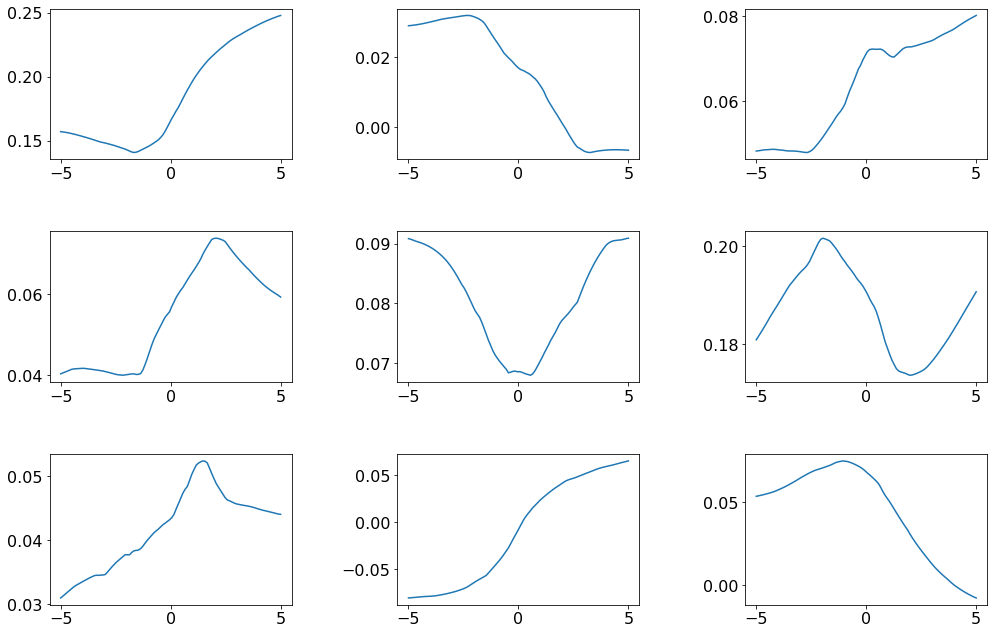

In [12]:
# create several ANNs and plot their dependence on x

x = torch.tensor( np.expand_dims(np.linspace(-5,5,100), axis=1)).float()
print(x.T)

N_examples = 9
m = int(np.ceil(np.sqrt(N_examples)))
N_hidden = 100

Nets = []

fig = plt.figure(figsize=(15,10))
for i in range(N_examples):
    
    Nets.append( MyNet(N_hidden, 3) ) 
    y = Nets[-1](x)

    plt.subplot(m,m,i+1)
    plt.plot(x.detach().numpy(), y.detach().numpy())
    plt.xticks( fontsize=16)
    plt.yticks( fontsize=16)
    plt.locator_params(axis='y', nbins=3)
    plt.locator_params(axis='x', nbins=3)
    
plt.tight_layout(pad=5)
plt.show()

In [13]:
for param in Nets[0].parameters():
    print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([100, 1])
<class 'torch.Tensor'> torch.Size([100])
<class 'torch.Tensor'> torch.Size([100, 100])
<class 'torch.Tensor'> torch.Size([100])
<class 'torch.Tensor'> torch.Size([100, 100])
<class 'torch.Tensor'> torch.Size([100])
<class 'torch.Tensor'> torch.Size([1, 100])
<class 'torch.Tensor'> torch.Size([1])


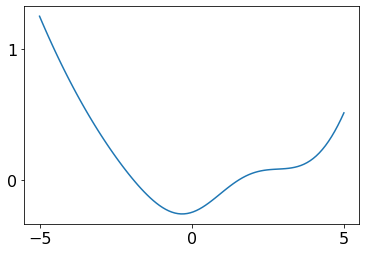

In [15]:
# let's try to make the ANN fit this function
f = lambda x : ( 5*np.sin(x)/(1+np.exp(-x)) + x**2-x-5 ) /20
x = np.linspace(-5,5,100)

plt.plot(x,f(x))
plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.locator_params(axis='y', nbins=3)
plt.locator_params(axis='x', nbins=3)
plt.show()

In [16]:
def PlotFit(net):
    
    x = np.linspace(-5,5,100)
    plt.plot(x, f(x))
    xt = torch.tensor(np.expand_dims(x,axis=1)).float()
    plt.plot(x, net(xt).detach().numpy(), color='r' )


def FitNet(net):
    
    mini_batch_size = 50

    print(net)
    PlotFit(net)
    plt.show()
    
    # copy the net so we can compare SGD and Adam
    net_cp = copy.deepcopy(net)

    # create  optimizer
    optimizer = optim.SGD(net.parameters(), lr=0.005)
    optimizer_cp = optim.Adam(net_cp.parameters(), lr=0.005)

    Nepochs = 1_000
    loss_hist = []
    loss_hist_cp = []

    for epoch in range(Nepochs):  # loop over the dataset multiple times


        # grab a minibatch -- randomize over the range -5 to 5
        x = 10*np.random.rand(mini_batch_size,1)-5
        xt = torch.tensor(x, dtype=torch.float)  

        # the target function
        targets =  f(xt)

        # zero the parameter gradients
        optimizer.zero_grad()
        optimizer_cp.zero_grad()

        # push inputs forward through the whole net
        outputs = net(xt)
        outputs_cp = net_cp(xt)

        
        # compute the loss associated with this output
        loss = torch.mean((outputs-targets)**2)
        loss_cp = torch.mean((outputs_cp-targets)**2)

        # propogate the sensitivity of the output to the model parameters 
        # backwards through the computational graph
        loss.backward()
        loss_cp.backward()

        # update the weights and biases by taking a SGD step
        optimizer.step()
        optimizer_cp.step()

        # store running loss
        loss_hist.append(  loss.item() )
        loss_hist_cp.append(  loss_cp.item() )

        # plot output every 50 iterations
        if( ( (epoch) % 200 == 0) and (epoch>10) ):
            print(epoch)
            plt.figure(figsize=(10,8))
            
            plt.subplot(2,2,1)
            plt.title('SGD')
            plt.plot(loss_hist)
            plt.yscale('log')
            
            plt.subplot(2,2,2)
            PlotFit(net)
            
            plt.subplot(2,2,3)
            plt.title('ADAM')
            plt.plot(loss_hist_cp)
            plt.yscale('log')
            
            plt.subplot(2,2,4)
            PlotFit(net_cp)
            
            plt.tight_layout(pad=2)
            plt.show()

    print(epoch)
    plt.figure(figsize=(10,8))

    plt.subplot(2,2,1)
    plt.title('SGD')
    plt.plot(loss_hist)
    plt.yscale('log')

    plt.subplot(2,2,2)
    PlotFit(net)

    plt.subplot(2,2,3)
    plt.title('ADAM')
    plt.plot(loss_hist_cp)
    plt.yscale('log')

    plt.subplot(2,2,4)
    PlotFit(net_cp)

    plt.tight_layout(pad=2)
    plt.show()

    print('Finished Training')
    
    return loss_hist, net, net_cp

MyNet(
  (prop_in_to_h): Linear(in_features=1, out_features=100, bias=True)
  (prop_h_to_out): Linear(in_features=100, out_features=1, bias=True)
)


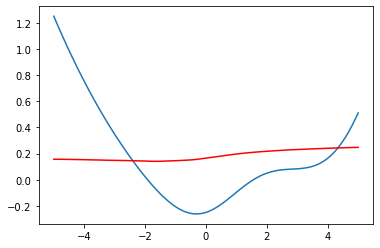

200


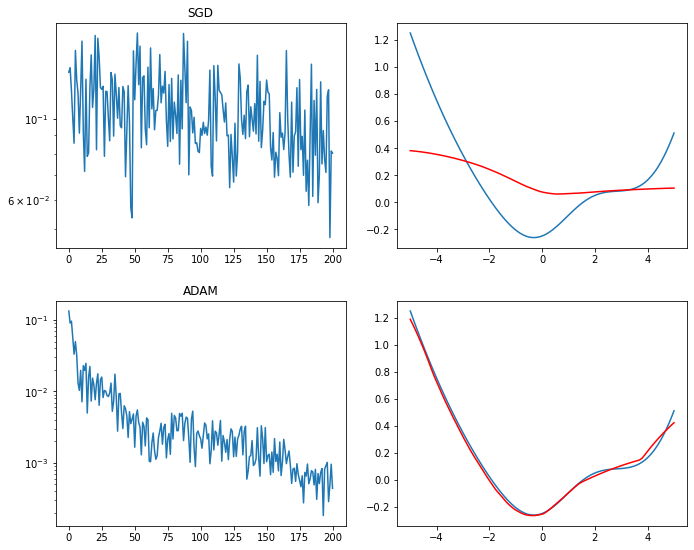

400


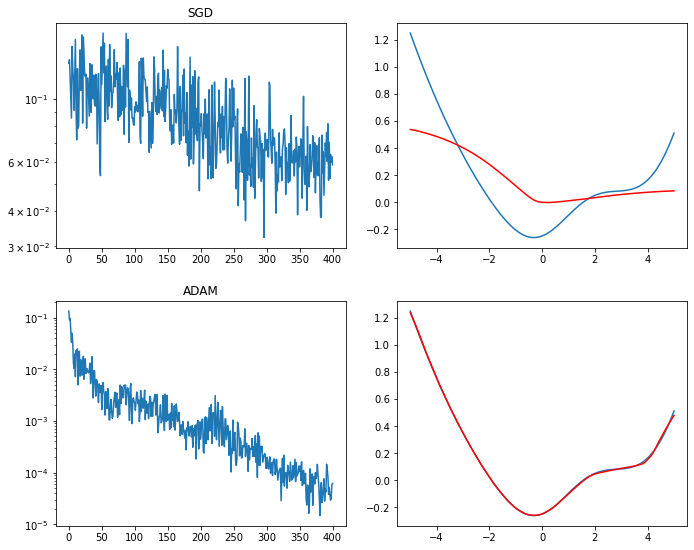

600


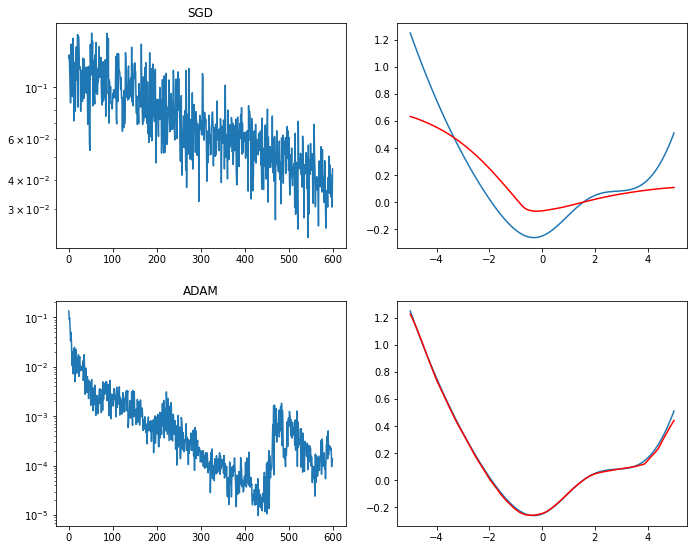

800


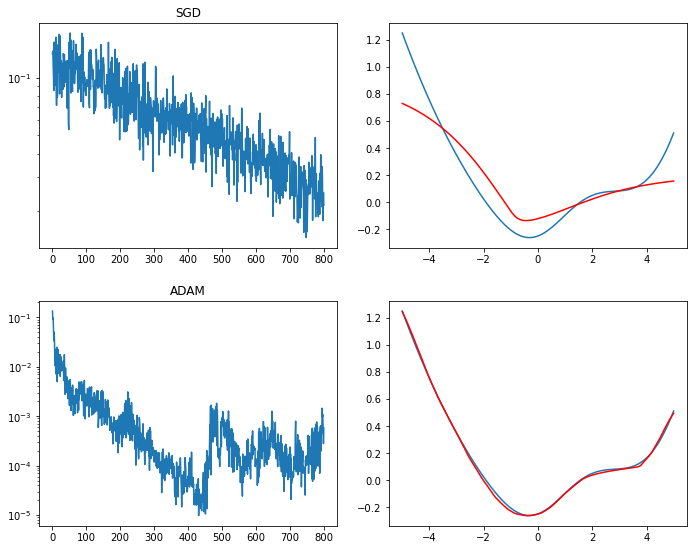

999


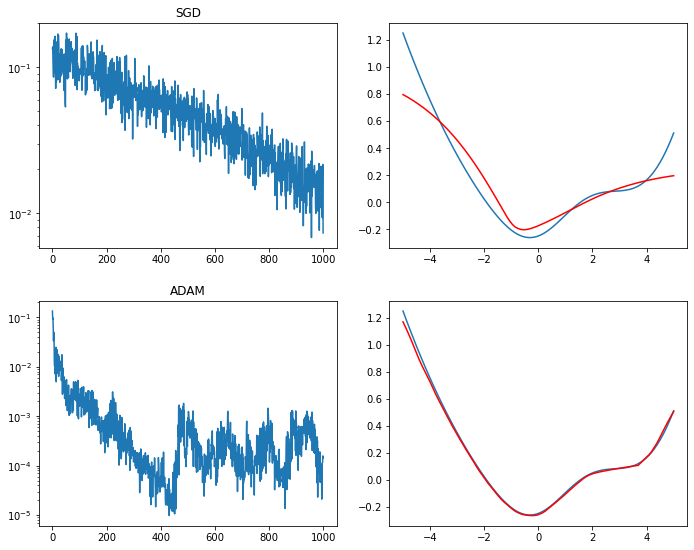

Finished Training


In [17]:
loss_hist, net, net_cp = FitNet(Nets[0])

MyNet(
  (prop_in_to_h): Linear(in_features=1, out_features=100, bias=True)
  (prop_h_to_out): Linear(in_features=100, out_features=1, bias=True)
)


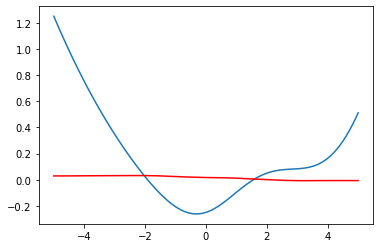

200


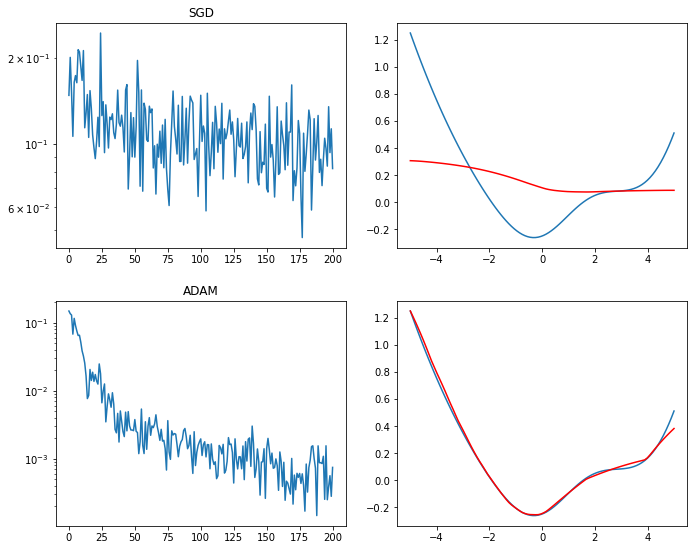

400


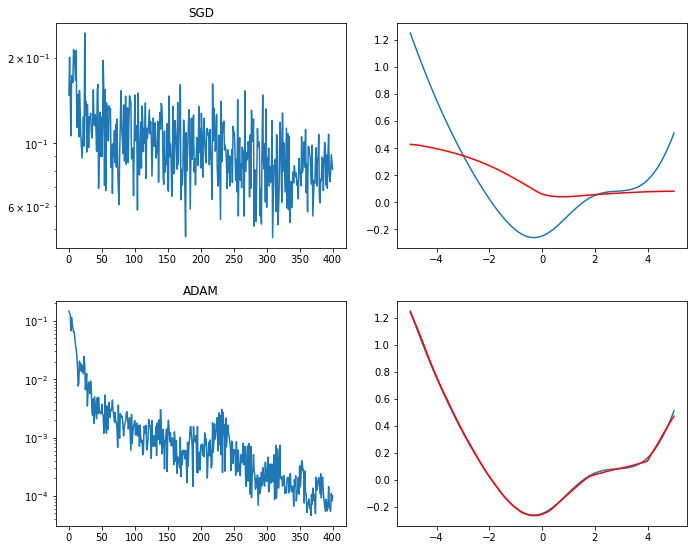

600


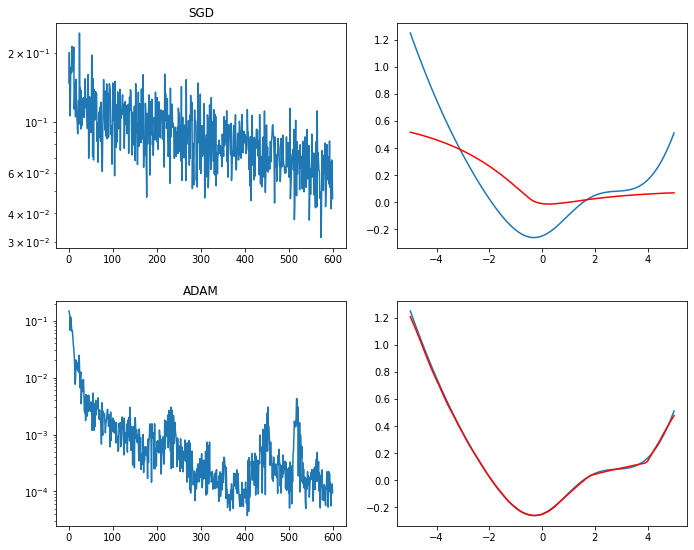

800


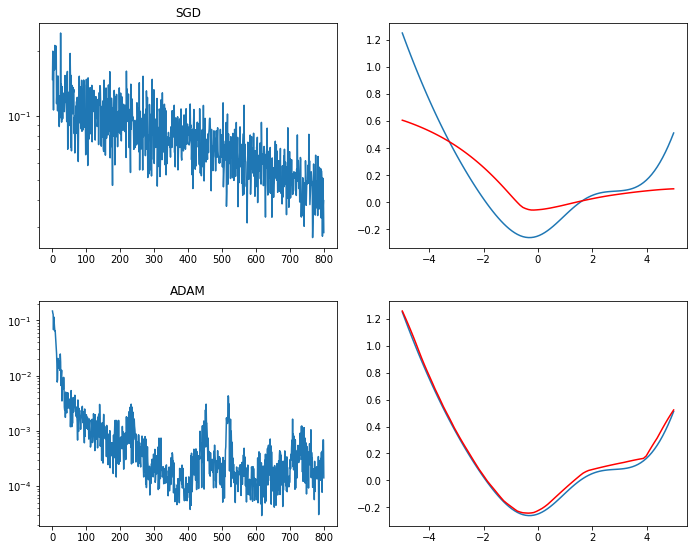

999


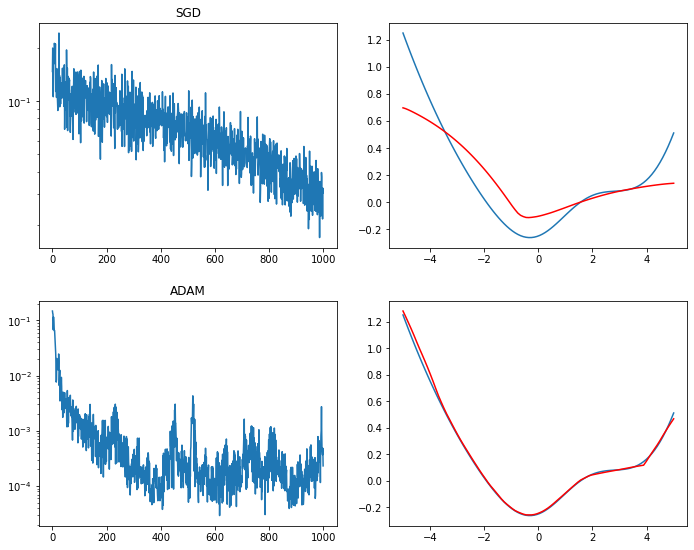

Finished Training


In [18]:
loss_hist, net, net_cp = FitNet(Nets[1])